In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython import display
import time

## Data Load

In [2]:
_URL = 'https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip'
path_to_zip = tf.keras.utils.get_file('cityscapes.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cityscapes/')
PATH

'/aiffel/.keras/datasets/cityscapes/'

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]
    
    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    
    real_image = tf.cast(real_image, tf.float32)
    input_image = tf.cast(input_image, tf.float32)
    
    return input_image, real_image

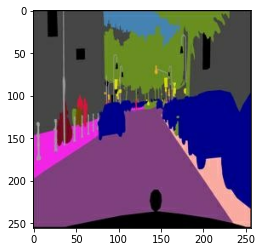

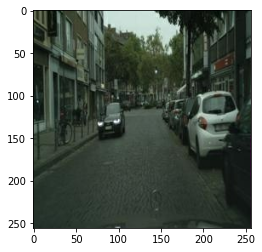

In [5]:
inp, re = load(PATH+'train/100.jpg')

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

## Argumentation

In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [8]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [9]:
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

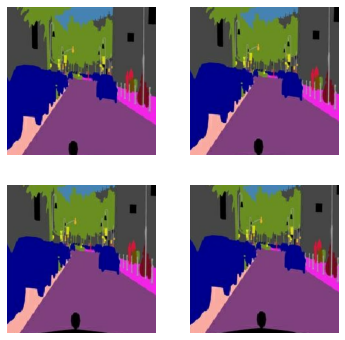

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

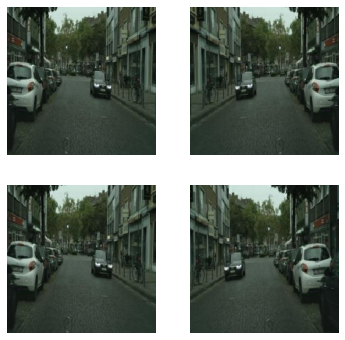

In [12]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_re/255.0)
    plt.axis('off')
plt.show()

In [13]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [14]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [15]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
BUFFER_SIZE = len(train_dataset)
BATCH_SIZE = 1

In [16]:
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [17]:
test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

-1.0 1.0


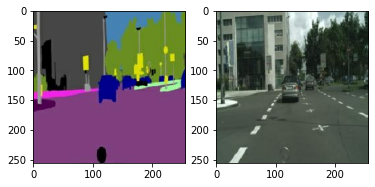

In [18]:
for sketch, real_image in train_dataset:
    print(np.min(sketch), np.max(sketch))
    plt.subplot(1,2,1)
    plt.imshow(denormalize(sketch[0]))
    plt.subplot(1,2,2)
    plt.imshow(denormalize(real_image[0]))
    plt.show()
    break

## Generator

In [19]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [20]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [21]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator

In [22]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [23]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [24]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## Train

In [25]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [26]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [27]:
@tf.function
def train_step(input_image, real_image):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        
        gen_output = generator(input_image, training=True)
        
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, real_image, training=True)
        
        gene_loss, l1_loss = get_gene_loss(gen_output, real_image, fake_disc)
        
        gene_total_loss = gene_loss + (100 * l1_loss)
        
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss
print("✅")

✅


In [28]:
# val_path = PATH+'val/'
test_input = []
for sketch, _ in test_dataset:
    test_input.append(sketch[0])

test_input = np.array(test_input)
test_input.shape

(5, 256, 256, 3)

In [29]:
os.makedirs('generated_images', exist_ok=True)

def generate_and_save_images(generator, epoch):
    predictions = generator(test_input, training=False)
    predictions = denormalize(predictions)
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(predictions[i])
        plt.axis("off")
        
    plt.suptitle(f"Epoch {epoch}")
    plt.show()
    plt.savefig('generated_images/image_at_epoch_{:04d}.png'.format(epoch))
# generate_and_save_images(generator, 1)

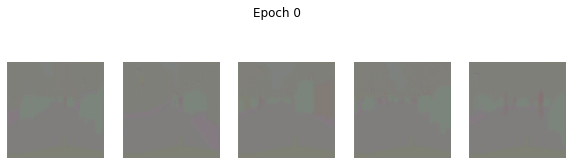

EPOCH[0 / 50]             
Generator_loss:2.5620             
L1_loss:0.1246             
Discriminator_loss:2.9884

spend time : 242.25447463989258


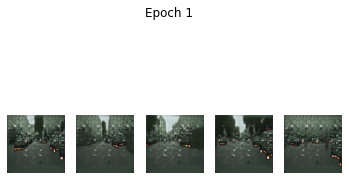

EPOCH[1 / 50]             
Generator_loss:0.5924             
L1_loss:0.1846             
Discriminator_loss:1.2409

spend time : 416.2759499549866


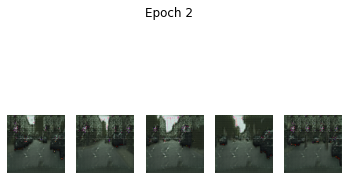

EPOCH[2 / 50]             
Generator_loss:0.9148             
L1_loss:0.1392             
Discriminator_loss:1.1625

spend time : 590.2591943740845


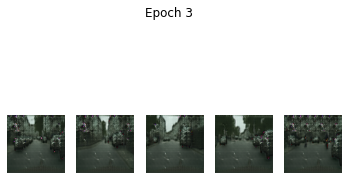

EPOCH[3 / 50]             
Generator_loss:1.6481             
L1_loss:0.2011             
Discriminator_loss:0.4347

spend time : 764.4401080608368


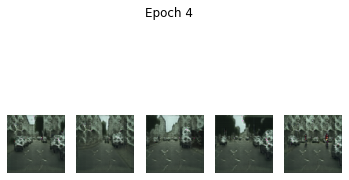

EPOCH[4 / 50]             
Generator_loss:1.0589             
L1_loss:0.2166             
Discriminator_loss:0.9292

spend time : 938.2695963382721


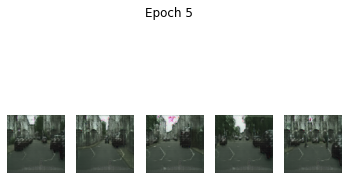

EPOCH[5 / 50]             
Generator_loss:2.5057             
L1_loss:0.1746             
Discriminator_loss:0.5845

spend time : 1112.084359884262


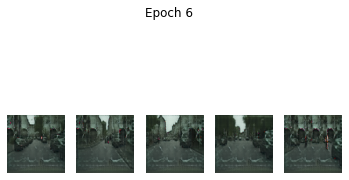

EPOCH[6 / 50]             
Generator_loss:0.5481             
L1_loss:0.1434             
Discriminator_loss:1.2380

spend time : 1286.0933883190155


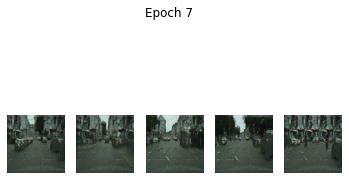

EPOCH[7 / 50]             
Generator_loss:1.6035             
L1_loss:0.1894             
Discriminator_loss:0.3392

spend time : 1460.1757879257202


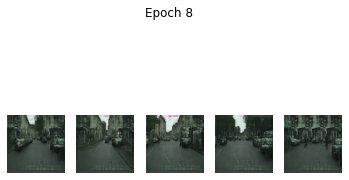

EPOCH[8 / 50]             
Generator_loss:3.1396             
L1_loss:0.2336             
Discriminator_loss:0.0585

spend time : 1634.0531289577484


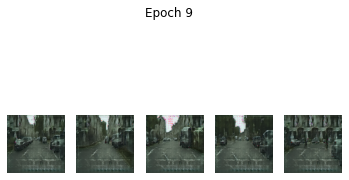

EPOCH[9 / 50]             
Generator_loss:1.8666             
L1_loss:0.1036             
Discriminator_loss:1.9567

spend time : 1807.8945217132568


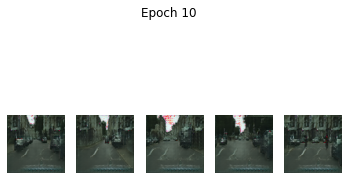

EPOCH[10 / 50]             
Generator_loss:1.3399             
L1_loss:0.1848             
Discriminator_loss:0.4048

spend time : 1981.8518197536469


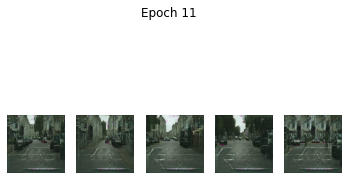

EPOCH[11 / 50]             
Generator_loss:1.6972             
L1_loss:0.2978             
Discriminator_loss:0.2446

spend time : 2155.6674003601074


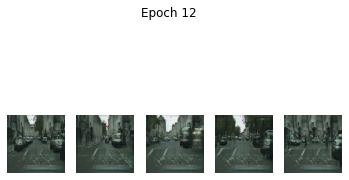

EPOCH[12 / 50]             
Generator_loss:2.0481             
L1_loss:0.1439             
Discriminator_loss:1.5289

spend time : 2329.663259744644


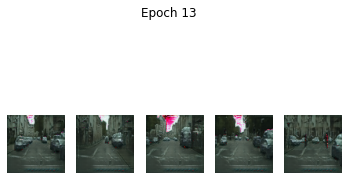

EPOCH[13 / 50]             
Generator_loss:1.1578             
L1_loss:0.1682             
Discriminator_loss:0.7137

spend time : 2503.4784870147705


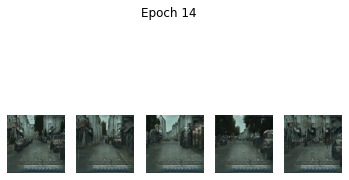

EPOCH[14 / 50]             
Generator_loss:1.6078             
L1_loss:0.1565             
Discriminator_loss:1.0285

spend time : 2677.2979896068573


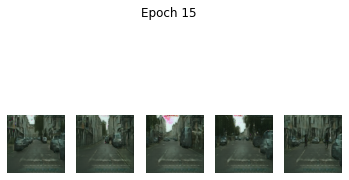

EPOCH[15 / 50]             
Generator_loss:0.5331             
L1_loss:0.1363             
Discriminator_loss:1.3489

spend time : 2851.126570224762


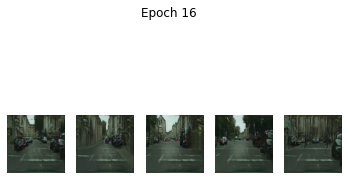

EPOCH[16 / 50]             
Generator_loss:2.6422             
L1_loss:0.1399             
Discriminator_loss:1.4582

spend time : 3024.956341266632


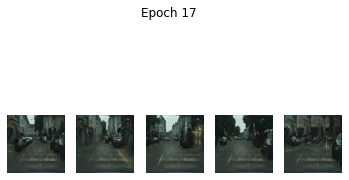

EPOCH[17 / 50]             
Generator_loss:1.0163             
L1_loss:0.1398             
Discriminator_loss:1.4409

spend time : 3198.9560782909393


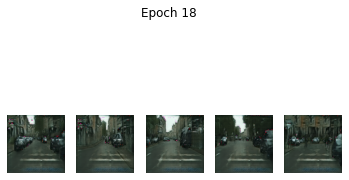

EPOCH[18 / 50]             
Generator_loss:0.8842             
L1_loss:0.1210             
Discriminator_loss:1.4890

spend time : 3372.778484106064


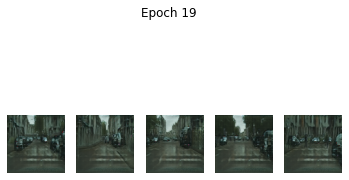

EPOCH[19 / 50]             
Generator_loss:2.0180             
L1_loss:0.1776             
Discriminator_loss:0.3186

spend time : 3546.7763183116913


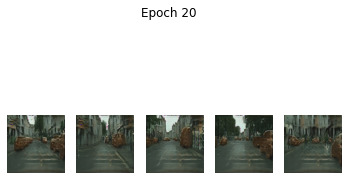

EPOCH[20 / 50]             
Generator_loss:1.7594             
L1_loss:0.1664             
Discriminator_loss:0.4836

spend time : 3720.725893974304


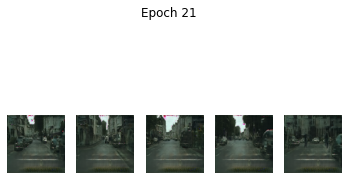

EPOCH[21 / 50]             
Generator_loss:1.6794             
L1_loss:0.1652             
Discriminator_loss:0.3008

spend time : 3894.7291207313538


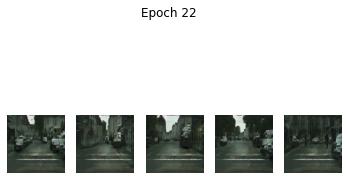

EPOCH[22 / 50]             
Generator_loss:0.7371             
L1_loss:0.1064             
Discriminator_loss:1.1953

spend time : 4068.535581111908


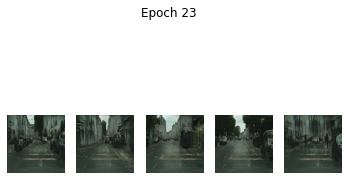

EPOCH[23 / 50]             
Generator_loss:2.1089             
L1_loss:0.1600             
Discriminator_loss:1.2005

spend time : 4242.358540773392


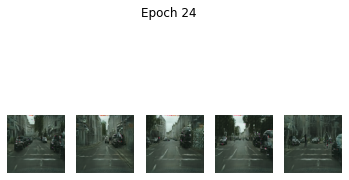

EPOCH[24 / 50]             
Generator_loss:0.7904             
L1_loss:0.1452             
Discriminator_loss:0.7316

spend time : 4416.340801477432


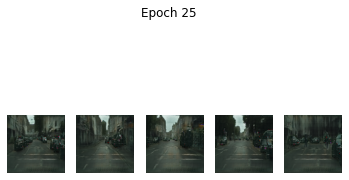

EPOCH[25 / 50]             
Generator_loss:0.4541             
L1_loss:0.1178             
Discriminator_loss:1.4572

spend time : 4590.180161714554


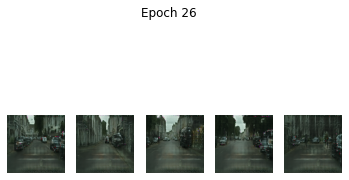

EPOCH[26 / 50]             
Generator_loss:2.0584             
L1_loss:0.1908             
Discriminator_loss:0.3192

spend time : 4764.131605863571


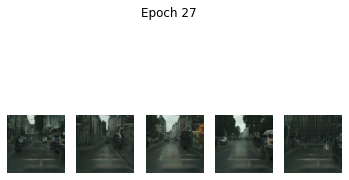

EPOCH[27 / 50]             
Generator_loss:1.2833             
L1_loss:0.1844             
Discriminator_loss:0.4920

spend time : 4938.139117240906


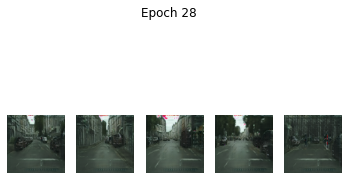

EPOCH[28 / 50]             
Generator_loss:3.2870             
L1_loss:0.1732             
Discriminator_loss:1.1670

spend time : 5111.954217910767


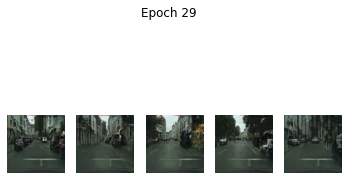

EPOCH[29 / 50]             
Generator_loss:1.0409             
L1_loss:0.1661             
Discriminator_loss:1.4768

spend time : 5285.771118879318


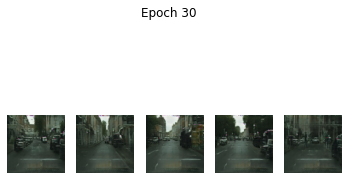

EPOCH[30 / 50]             
Generator_loss:1.4562             
L1_loss:0.2267             
Discriminator_loss:0.4862

spend time : 5459.585448503494


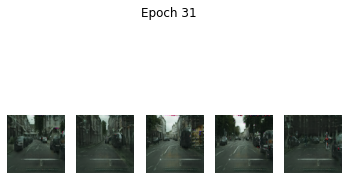

EPOCH[31 / 50]             
Generator_loss:1.6545             
L1_loss:0.1748             
Discriminator_loss:0.5128

spend time : 5633.590334653854


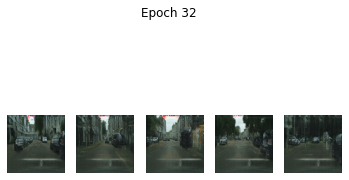

EPOCH[32 / 50]             
Generator_loss:0.5527             
L1_loss:0.2646             
Discriminator_loss:1.0286

spend time : 5807.409545660019


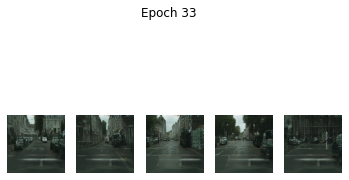

EPOCH[33 / 50]             
Generator_loss:2.1813             
L1_loss:0.2062             
Discriminator_loss:0.1705

spend time : 5981.213560819626


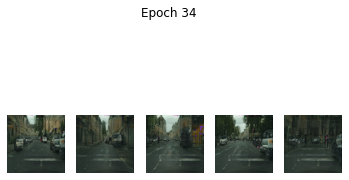

EPOCH[34 / 50]             
Generator_loss:1.6486             
L1_loss:0.1573             
Discriminator_loss:0.2795

spend time : 6154.852921962738


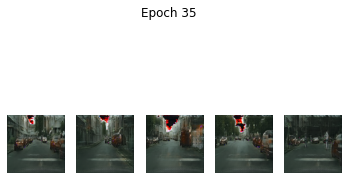

EPOCH[35 / 50]             
Generator_loss:2.9906             
L1_loss:0.1124             
Discriminator_loss:2.1714

spend time : 6328.690344333649


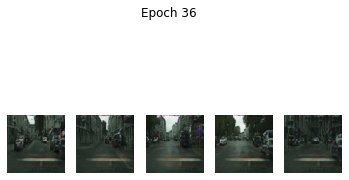

EPOCH[36 / 50]             
Generator_loss:0.4791             
L1_loss:0.1406             
Discriminator_loss:1.3799

spend time : 6502.513826847076


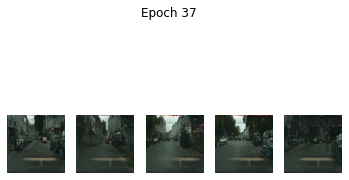

EPOCH[37 / 50]             
Generator_loss:1.3854             
L1_loss:0.1425             
Discriminator_loss:1.2894

spend time : 6676.327300310135


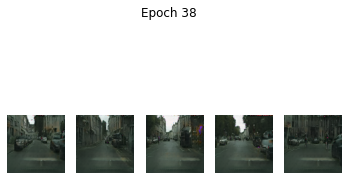

EPOCH[38 / 50]             
Generator_loss:0.5301             
L1_loss:0.1378             
Discriminator_loss:1.6369

spend time : 6850.328643798828


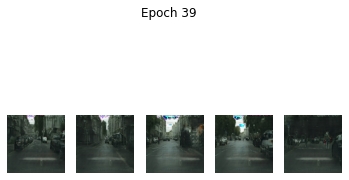

EPOCH[39 / 50]             
Generator_loss:1.8529             
L1_loss:0.1912             
Discriminator_loss:0.2266

spend time : 7024.1385679244995


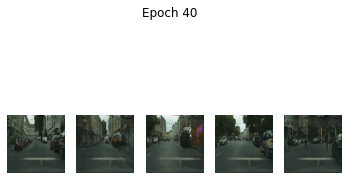

EPOCH[40 / 50]             
Generator_loss:2.0430             
L1_loss:0.1737             
Discriminator_loss:0.6148

spend time : 7197.968041181564


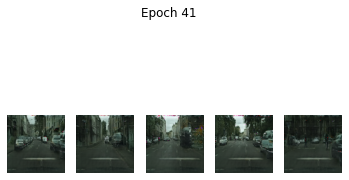

EPOCH[41 / 50]             
Generator_loss:0.8120             
L1_loss:0.1415             
Discriminator_loss:1.5218

spend time : 7371.767478227615


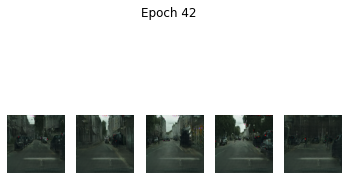

EPOCH[42 / 50]             
Generator_loss:1.6810             
L1_loss:0.1410             
Discriminator_loss:0.6402

spend time : 7545.571627140045


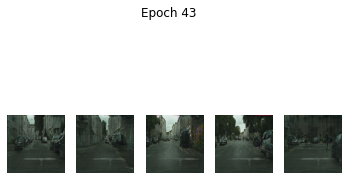

EPOCH[43 / 50]             
Generator_loss:0.7866             
L1_loss:0.1628             
Discriminator_loss:0.9403

spend time : 7719.372209310532


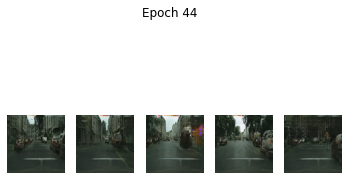

EPOCH[44 / 50]             
Generator_loss:0.8530             
L1_loss:0.2252             
Discriminator_loss:0.7738

spend time : 7893.031827688217


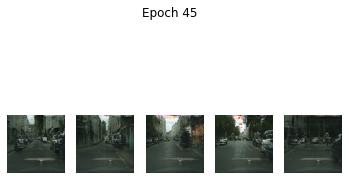

EPOCH[45 / 50]             
Generator_loss:1.1393             
L1_loss:0.1471             
Discriminator_loss:0.5566

spend time : 8066.991901874542


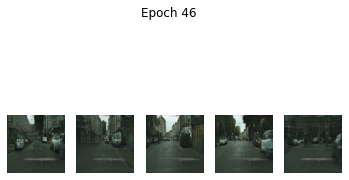

EPOCH[46 / 50]             
Generator_loss:1.6401             
L1_loss:0.1082             
Discriminator_loss:1.5489

spend time : 8240.825659513474


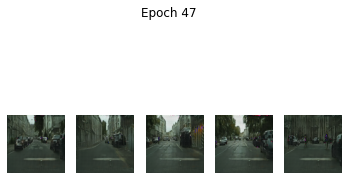

EPOCH[47 / 50]             
Generator_loss:1.9997             
L1_loss:0.1479             
Discriminator_loss:0.9640

spend time : 8414.460515499115


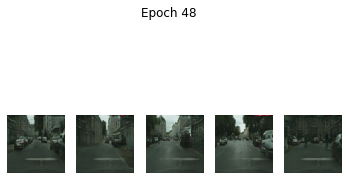

EPOCH[48 / 50]             
Generator_loss:2.1821             
L1_loss:0.1817             
Discriminator_loss:0.2658

spend time : 8588.284164428711


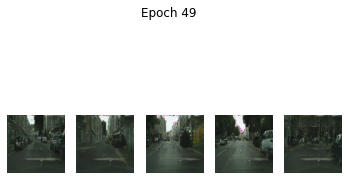

EPOCH[49 / 50]             
Generator_loss:1.7993             
L1_loss:0.1690             
Discriminator_loss:1.1829

spend time : 8762.082897663116


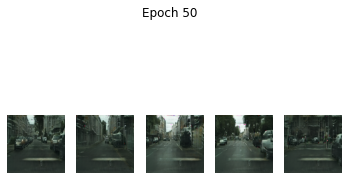

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize=(10, 3))

EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

start_time = time.time()

for epoch in range(EPOCHS):
    generate_and_save_images(generator, epoch)        
    for i, (input_image, real_image) in enumerate(train_dataset):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)
    
    print(f"EPOCH[{epoch} / {EPOCHS}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    print("spend time : {}".format(time.time() - start_time))

generate_and_save_images(generator, EPOCHS)

## Test

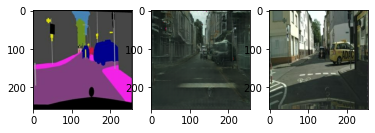

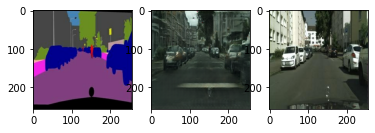

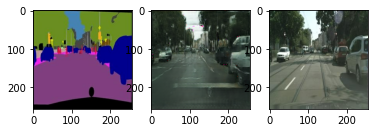

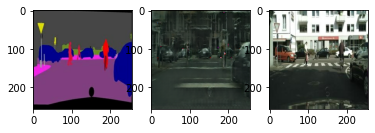

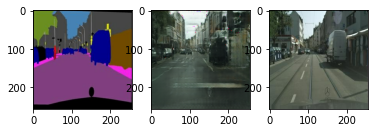

In [45]:
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

for sketch, real_image in test_dataset:
    plt.subplot(1,3,1)
    plt.imshow(denormalize(sketch[0]))
    plt.subplot(1,3,2)
    plt.imshow(denormalize(generator(sketch)[0]))
    plt.subplot(1,3,3)
    plt.imshow(denormalize(real_image[0]))
    plt.show()